In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import os
from IPython.display import display, Image
from IPython import display
import json

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


**LOAD DATA**

In [ ]:
# !gdown ........... -O /content/data.zip

In [ ]:
%%capture
!mkdir /content/data
!unzip "/content/data.zip" -d "/content/data"

In [ ]:
import json
import os
import shutil
from pathlib import Path
from tqdm import tqdm

def convert_coco_to_yolo(json_path, image_dir, output_dir, type_split):
    save_img_dir = Path(output_dir) / 'images' / type_split
    save_lbl_dir = Path(output_dir) / 'labels' / type_split
    save_img_dir.mkdir(parents=True, exist_ok=True)
    save_lbl_dir.mkdir(parents=True, exist_ok=True)

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    images = {item['id']: item for item in data['images']}

    img_anns = {item['id']: [] for item in data['images']}
    for ann in data['annotations']:
        img_anns[ann['image_id']].append(ann)

    print(f"Converting {type_split} data...")

    for img_id, img_info in tqdm(images.items()):
        file_name = img_info['file_name']

        src_img_path = os.path.join(image_dir, file_name)
        dst_img_path = save_img_dir / file_name

        if os.path.exists(src_img_path):
            shutil.copy(src_img_path, dst_img_path)
        else:
            print(f"Warning: Image {file_name} not found!")
            continue

        img_w, img_h = img_info['width'], img_info['height']
        txt_name = Path(file_name).stem + '.txt'

        with open(save_lbl_dir / txt_name, 'w') as f_txt:
            for ann in img_anns[img_id]:
                cat_id = ann['category_id'] - 1

                bbox = ann['bbox'] # x_min, y_min, w, h

                x_center = (bbox[0] + bbox[2]/2) / img_w
                y_center = (bbox[1] + bbox[3]/2) / img_h
                w = bbox[2] / img_w
                h = bbox[3] / img_h

                f_txt.write(f"{cat_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

all_images_dir = "/content/data/All_Dataset"

output_root = "/content/my_dataset_yolo"

convert_coco_to_yolo("/content/drive/MyDrive/New_BBox_Dataset/train_test_split_version/ver_6/left_out_cha_mieng_fix_cha_ca/background_v5/train.json", all_images_dir, output_root, "train")
convert_coco_to_yolo("/content/drive/MyDrive/New_BBox_Dataset/train_test_split_version/ver_6/left_out_cha_mieng_fix_cha_ca/background_v5/val.json",   all_images_dir, output_root, "val")
convert_coco_to_yolo("/content/drive/MyDrive/New_BBox_Dataset/train_test_split_version/ver_6/left_out_cha_mieng_fix_cha_ca/background_v5/test.json",  all_images_dir, output_root, "test")

Converting train data...


100%|██████████| 634/634 [00:02<00:00, 242.59it/s]


Converting val data...


100%|██████████| 77/77 [00:00<00:00, 1638.07it/s]


Converting test data...


100%|██████████| 76/76 [00:00<00:00, 1457.96it/s]


In [ ]:
!pip install ultralytics wandb -q

import wandb
from ultralytics import YOLO
from google.colab import drive
import os
import shutil
import yaml

wandb.login()

run = wandb.init(project="Food_Project_WandB", name="Run_L4_Final_Fixed", mode="online")

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
drive_save_path = '/content/drive/MyDrive/Food_Project_Backup/Final/ver_6/best/original/left_out_cha_mieng_fix_cha_ca/background_v5'
os.makedirs(drive_save_path, exist_ok=True)

# Tạo file data.yaml
dataset_config = {
    'path': '/content/my_dataset_yolo',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {
        0: 'suon_non', 1: 'suon_cot_let', 2: 'cha_cat_lat',
        3: 'cha_mieng', 4: 'tofu_chien', 5: 'tofu_trang'
    }
}
with open('data.yaml', 'w') as f:
    yaml.dump(dataset_config, f)

model = YOLO("yolo11s.pt")

hyperparams = {
    'batch': 16,
    'device': 0,
    'workers': 4,
    'cache': False,
    'epochs': 250,
    'patience': 75,
    'imgsz': 1024,

    'optimizer': 'AdamW',
    'lr0': 0.0013,
    'cos_lr': True,

    'cls': 1.2,
    'box': 7.0,

    'dropout': 0.3,
    'weight_decay': 0.001,
    'label_smoothing': 0.1,

    'hsv_h': 0.015,
    'hsv_s': 0.6,
    'hsv_v': 0.4,
    'degrees': 30.0,
    'translate': 0.1,
    'scale': 0.6,
    'perspective': 0.0005,
    'fliplr': 0.5,
    'flipud': 0.0,

    'mosaic': 1.0,
    'mixup': 0.25,
    'copy_paste': 0.3,

    'close_mosaic': 40
}

print(f"🚀 Link theo dõi biểu đồ: {run.get_url()}")

results = model.train(
    data='data.yaml',
    project="Food_Project_WandB",
    name="Run_L4_Final_Fixed",
    exist_ok=True,
    **hyperparams
)

print("Training Completed.")

wandb.finish()

local_best_path = 'Food_Project_WandB/Run_L4_Final_Fixed/weights/best.pt'
drive_dest_path = f'{drive_save_path}/model_new_hyper_1024_imgsz_16_batch.pt'

if os.path.exists(local_best_path):
    shutil.copy(local_best_path, drive_dest_path)
    print(f"Đã lưu model an toàn vào: {drive_dest_path}")
else:
    print("Không tìm thấy file best.pt!")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: linhpham2003zx (linhpham2003zx-h-c-vi-n-c-ng-ngh-b-u-ch-nh-vi-n-th-ng-c-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


🚀 Link theo dõi biểu đồ: https://wandb.ai/linhpham2003zx-h-c-vi-n-c-ng-ngh-b-u-ch-nh-vi-n-th-ng-c-/Food_Project_WandB/runs/9ct5wdfy
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.0, cache=False, cfg=None, classes=None, close_mosaic=40, cls=1.2, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=30.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.3, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.6, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0013, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.25, mode=train, model=yolo11s.p

✅ Đã lưu model an toàn vào: /content/drive/MyDrive/Food_Project_Backup/Final/ver_6/best/original/left_out_cha_mieng_fix_cha_ca/background_v5/model_new_hyper_1024_imgsz_16_batch.pt


💾 Đã lưu ảnh biểu đồ vào: /content/drive/MyDrive/New_BBox_Dataset/result_train/ver_6/best/left_out_cha_mieng_fix_cha_ca/training_metrics_new_hyper_1024_imgsz_16_batch.png


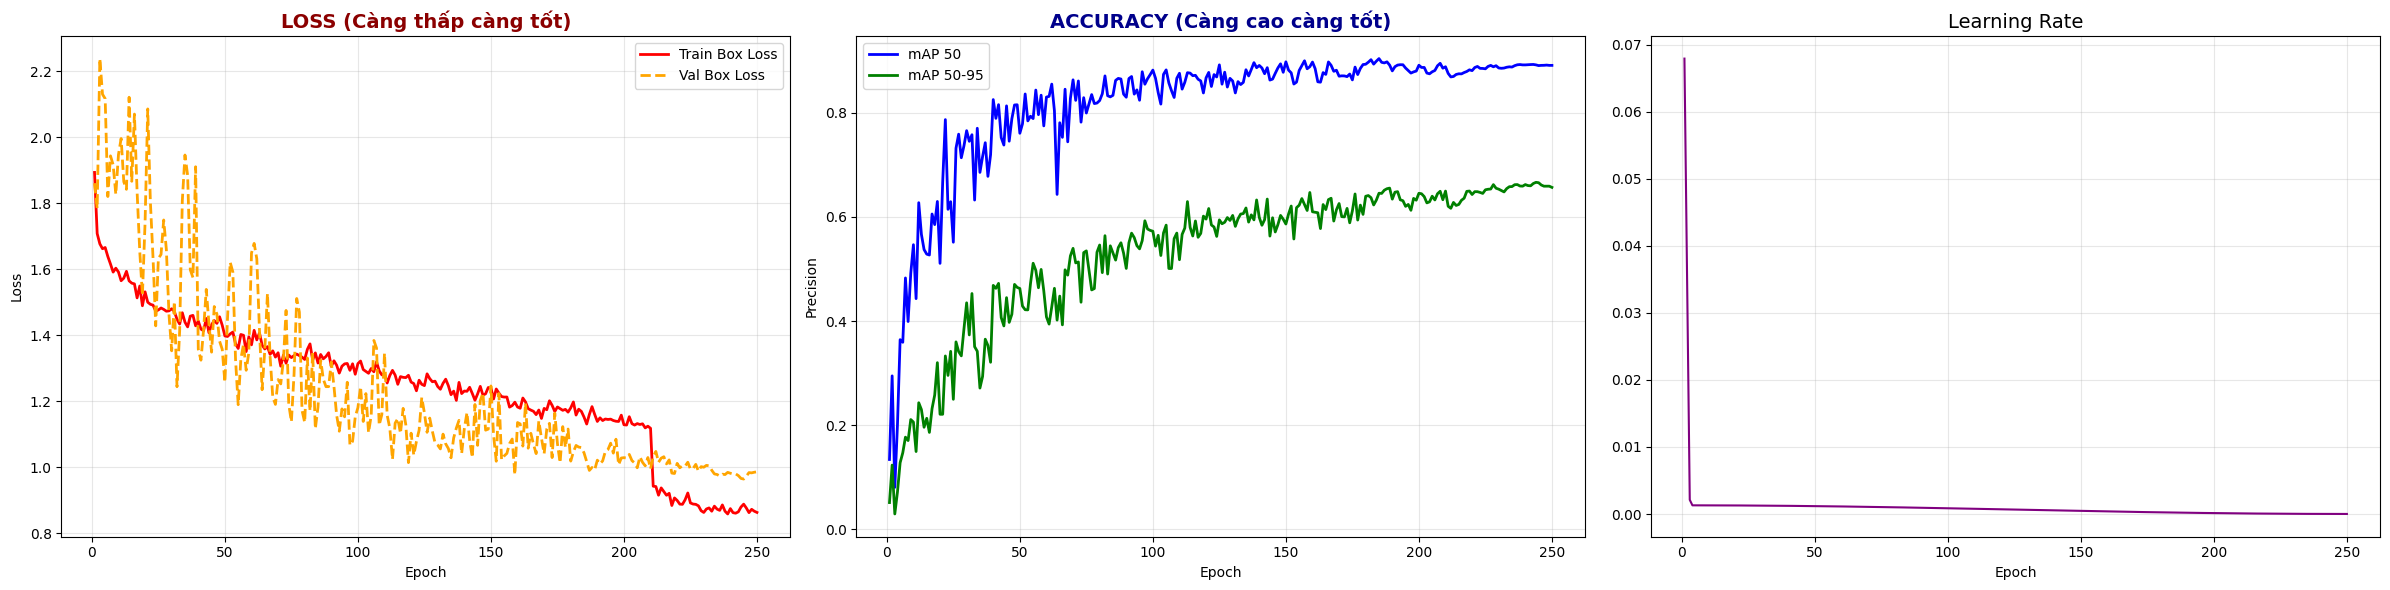

✅ Đã vẽ và lưu biểu đồ dựa trên 250 Epochs đầu tiên.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = '/content/Food_Project_WandB/Run_L4_Final_Fixed/results.csv'

save_dir = '/content/drive/MyDrive/New_BBox_Dataset/result_train/ver_6/best/left_out_cha_mieng_fix_cha_ca'
image_name = 'training_metrics_new_hyper_1024_imgsz_16_batch.png'
save_path = os.path.join(save_dir, image_name)

if os.path.exists(csv_path):
    try:
        os.makedirs(save_dir, exist_ok=True)

        df = pd.read_csv(csv_path)
        df.columns = df.columns.str.strip()

        fig, ax = plt.subplots(1, 3, figsize=(24, 6))

        ax[0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='red', linewidth=2)
        if 'val/box_loss' in df.columns:
            ax[0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='orange', linestyle='--', linewidth=2)
        ax[0].set_title('LOSS (Càng thấp càng tốt)', fontsize=14, fontweight='bold', color='darkred')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].legend()
        ax[0].grid(True, alpha=0.3)

        ax[1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP 50', color='blue', linewidth=2)
        ax[1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP 50-95', color='green', linewidth=2)
        ax[1].set_title('ACCURACY (Càng cao càng tốt)', fontsize=14, fontweight='bold', color='darkblue')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Precision')
        ax[1].legend()
        ax[1].grid(True, alpha=0.3)

        if 'lr/pg0' in df.columns:
            ax[2].plot(df['epoch'], df['lr/pg0'], color='purple')
            ax[2].set_title('Learning Rate', fontsize=14)
            ax[2].set_xlabel('Epoch')
            ax[2].grid(True, alpha=0.3)

        plt.tight_layout()

        plt.savefig(save_path, dpi=300)
        print(f"Đã lưu ảnh biểu đồ vào: {save_path}")

        plt.show()

        print(f"Đã vẽ và lưu biểu đồ dựa trên {len(df)} Epochs đầu tiên.")

    except Exception as e:
        print(f"Có lỗi khi xử lý: {e}")
else:
    print(f"Không tìm thấy file tại: {csv_path}")
    print("Hãy kiểm tra lại đường dẫn file results.csv ở cột bên trái.")